# Mie scattering from PMDI droplets

This program estimates light scattering from spherical droplets to approximate optical PMDI experiments.
    
    @author Daniel Duke <daniel.duke@monash.edu>
    @copyright (c) 2020 LTRAC
    @license GPL-3.0+
    @version 0.0.1
    @date 06/05/2020
        __   ____________    ___    ______
       / /  /_  ____ __  \  /   |  / ____/
      / /    / /   / /_/ / / /| | / /
     / /___ / /   / _, _/ / ___ |/ /_________
    /_____//_/   /_/ |__\/_/  |_|\__________/

    Laboratory for Turbulence Research in Aerospace & Combustion (LTRAC)
    Monash University, Australia


In [54]:
# Load modules
import numpy as np
import scipy.special 
import scipy.integrate
import matplotlib.pyplot as plt
import sys
from joblib import Parallel, delayed
%matplotlib notebook


In [43]:
# Absorption and Scattering of Light by Small Particles
# (Book by Craig Bohren and Donald Huffman)
# Ch6. SCATTERING BY AN ISOTROPIC, HOMOGENEOUS SPHERE.



# Mie coefficients a_n, b_n
# n is the summation series index
# m is complex refractive index
# x is the size parameter
# rbvals are Ricatti-Bessel functions pre-evaluated.
def mie_coeffs(n, m, x, rbvals):
    
    jn, jnp, jm, jmp, yn, ynp = rbvals
    
    # Logarithmic derivative (d/dx)ln(Psi_n(m*x))
    # using chain rule, this is Psi'_n(m*x)/Psi_n(m*x)
    logderiv = jmp[n]/complex(jm[n]+1e-99)
    
    # Evaluate A
    A = ((logderiv/complex(m)) + (n/complex(x)))
    a_numr = A*jn[n] - jn[n-1] #A*ricattiBesselPsi(x,n) - ricattiBesselPsi(x,n-1)
    a_deno = A*yn[n] - yn[n-1] #A*ricattiBesselXi(x,n) - ricattiBesselXi(x,n-1)
    a_deno += 1e-99
    
    # Evaluate B
    B = ((m*logderiv/complex(m)) + (n/complex(x)))
    b_numr = B*jn[n] - jn[n-1] #B*ricattiBesselPsi(x,n) - ricattiBesselPsi(x,n-1)
    b_deno = B*yn[n] - yn[n-1] #B*ricattiBesselXi(x,n) - ricattiBesselXi(x,n-1)
    b_deno += 1e-99
    
    return a_numr/a_deno, b_numr/b_deno


# Extinction & Scattering cross sections
# r is the radius of the scattering sphere.
# k is the wavenumber of incident light
# m is complex refractive index of the sphere relative to the surroundings
def CrossSections(k,m,r):

    # Enforce a complex refractive index for type matching
    m = complex(m)
    
    # Size parameter
    x = k*r
    
    # n_max from BHMIE. Too large n_max can cause unacceptable round-off error!
    n_max = int(np.floor(x + 4*(x**0.3333) + 2))
    if n_max < 1: n_max=1
    
    # Calculate Riccati-Bessel functions up to n_max
    jn, jnp = scipy.special.riccati_jn(n_max,x)   # Psi_n(x)
    jm, jmp = scipy.special.riccati_jn(n_max,m*x) # Psi_n(m*x)
    yn, ynp = scipy.special.riccati_yn(n_max,x)   # Xi_n(x)
    rbvals = (jn, jnp, jm, jmp, yn, ynp)
    
    # Summation series
    s_ext = 0
    s_sca = 0
    
    for n in np.arange(1,n_max+1):
        an, bn = mie_coeffs(n,m,x,rbvals)
        s_ext += (2*n+1)*np.real(an + bn)
        s_sca += (2*n+1)*(np.abs(an)**2 + np.abs(bn)**2)
    
        
    # Multiply by the coefficient outside the summation    
    s_ext *= 2 * np.pi / (k**2 + 1e-99)
    s_sca *= 2 * np.pi / (k**2 + 1e-99)
    
    return np.abs(s_ext), np.abs(s_sca)


# Rayleigh scattering cross section - proportional only
def Rayleigh(k,m,r):
    lam=2*np.pi/float(k)
    return (2*(np.pi**5)*((2*r)**6)/(3*lam**4))*np.abs((m**2 - 1)/(m**2 + 2))**2



lambda = 450 nm, m = 0.340269 + 3.3e-10 i


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 1252 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 1702 tasks      | elapsed:    0.7s


lambda = 550 nm, m = 0.335322 + 2.47e-09 i


[Parallel(n_jobs=16)]: Done 2000 out of 2000 | elapsed:    1.8s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 1252 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 1732 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done 2000 out of 2000 | elapsed:    1.5s finished


<IPython.core.display.Javascript object>


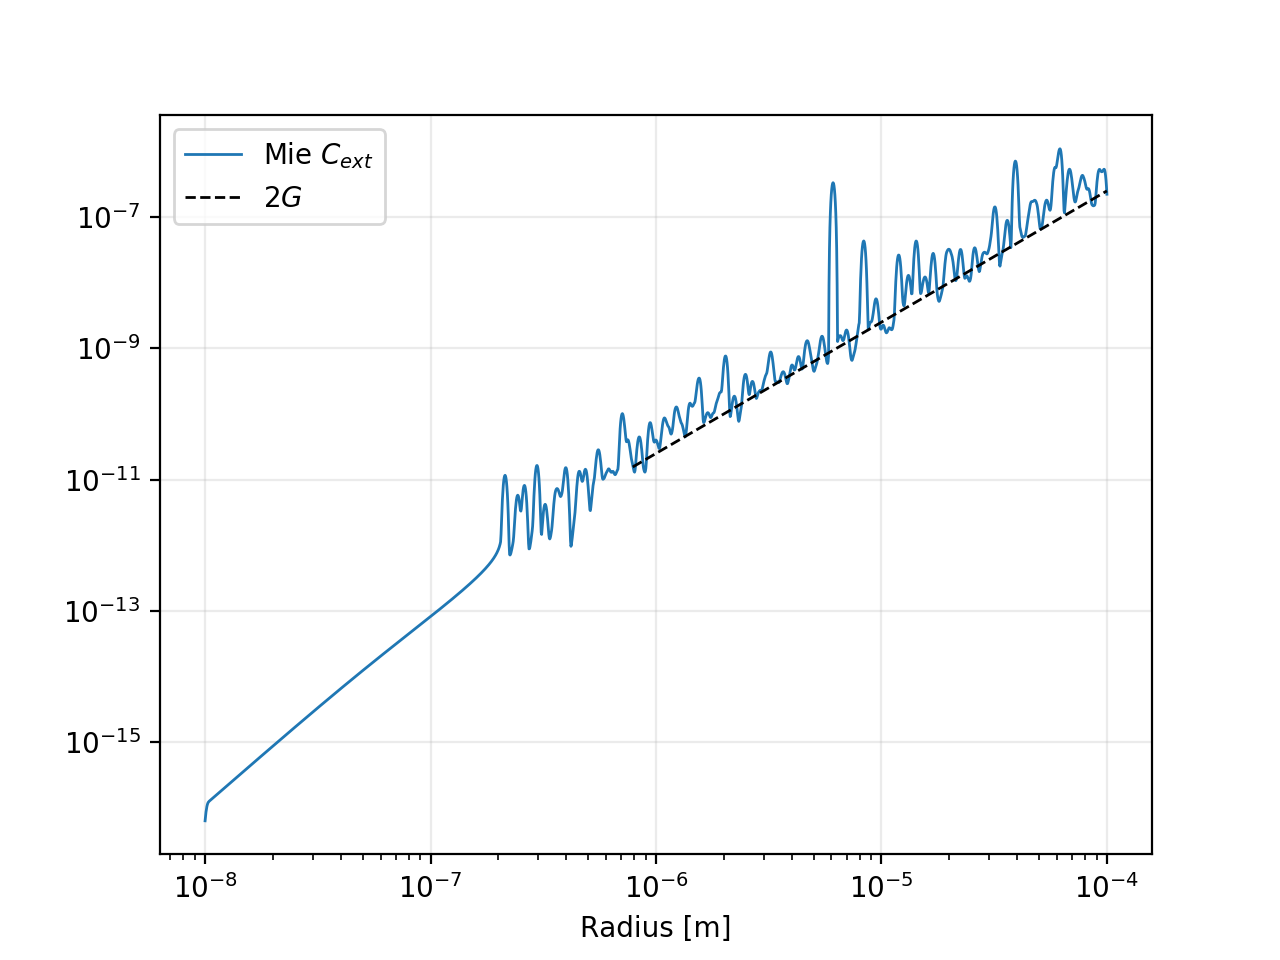

In [60]:
# testing - constants
lam    = np.array([450.0e-9         , 550.0e-9])
m_air  = np.array([1.00028053+0j    , 1.00027784+0j])
m      = np.array([1.34055+3.30e-10j, 1.33560 + 2.47e-09j])  # water in air at 450 & 550nm
radii  = np.logspace(-8,-4,2000)
n_tasks = 16

m -= m_air # difference in refractive index
k = 2*np.pi/lam
x_med = np.median(k)*radii


# result is shape [n_max,2] with C_ext and C_scatt. in each column.
# Repeat for each wavelength of light.
results = []
for i in range(len(lam)):
    print("lambda = %g nm, m = %g + %g i" % (lam[i]*1e9, m[i].real, m[i].imag))
    sys.stdout.flush()
    result = Parallel(n_jobs=n_tasks,verbose=5,batch_size=32)(delayed(CrossSections)(k[i],m[i],r) for r in radii)
    results.append(np.array(result))
results = np.dstack(results)

# Average over wavelengths
result = np.mean(np.nan_to_num(results),axis=2)
result[result<=0] = np.nan

# Smoothing
wl=21
window = np.hanning(wl)
window /= scipy.integrate.simps(window)
for i in range(2):
    result[:,i] = np.convolve(result[:,i], window, 'same')

# Geometric cross section
G = 4*np.pi*radii**2

# plot
fig=plt.figure()
ax=fig.add_subplot(111)
plt.xlabel('Radius [m]')
plt.grid(alpha=.25)

ax.plot(radii, result[:,0], label=r'Mie $C_{ext}$', lw=1)
ax.plot(radii[x_med>=10], 2*G[x_med>=10], label=r'$2G$',lw=1,c='k',ls='--')
#ax.plot(radii[x_med<1], Rayleigh(np.mean(k),np.mean(m),radii[x_med<1]),ls='--',lw=1,label='Rayleigh Scatter')

plt.yscale('log')
plt.xscale('log')

plt.legend()
plt.show()